In [1]:
## NOTE: Install libraries here
import sys

!{sys.executable} -m pip install -q pandas seaborn wordcloud nltk scikit-learn fasttext

In [2]:
import string

import fasttext
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import seaborn as sns
from IPython import display
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, f1_score
from wordcloud import STOPWORDS, ImageColorGenerator, WordCloud

In [3]:
!ls

assignment1_01_Word_Vectors.ipynb  fasttext_corpus.txt	README.md
catboost_info			   kontyp.ipynb		task
comments.tsv			   model		wr.ipynb


In [4]:
data = pd.read_csv("task/dataset/train.tsv", sep="\t")

In [5]:
data.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [6]:
data.shape

(5758, 2)

In [7]:
data["is_fake"].value_counts(normalize=True)

1    0.5
0    0.5
Name: is_fake, dtype: float64

In [8]:
data.isnull().sum()

title      0
is_fake    0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


In [10]:
# NOTE: I would perform cleaning separatly before visualization and modeling

## Text cleaning and normalization

In [11]:
# to lower case
data["title_cleaned"] = data["title"].str.lower()
# remove puncluations
data["title_cleaned"] = data["title_cleaned"].apply(
    lambda text: text.translate(str.maketrans("", "", string.punctuation))
)
data["title_cleaned"] = data["title_cleaned"].apply(lambda text: text.replace("«", ""))
data["title_cleaned"] = data["title_cleaned"].str.strip()

In [12]:
# remove stop words
stop_words = stopwords.words("russian")
stop_words.append("изза")
# NOTE: usually _ used in loop only if you are not using this variable in the loop
def remove_stopwords(text: str) -> str:
    result = []
    for token in text.split():
        if token not in stop_words:
            result.append(token)
    return " ".join(result)


data["title_cleaned"] = data["title_cleaned"].apply(remove_stopwords)

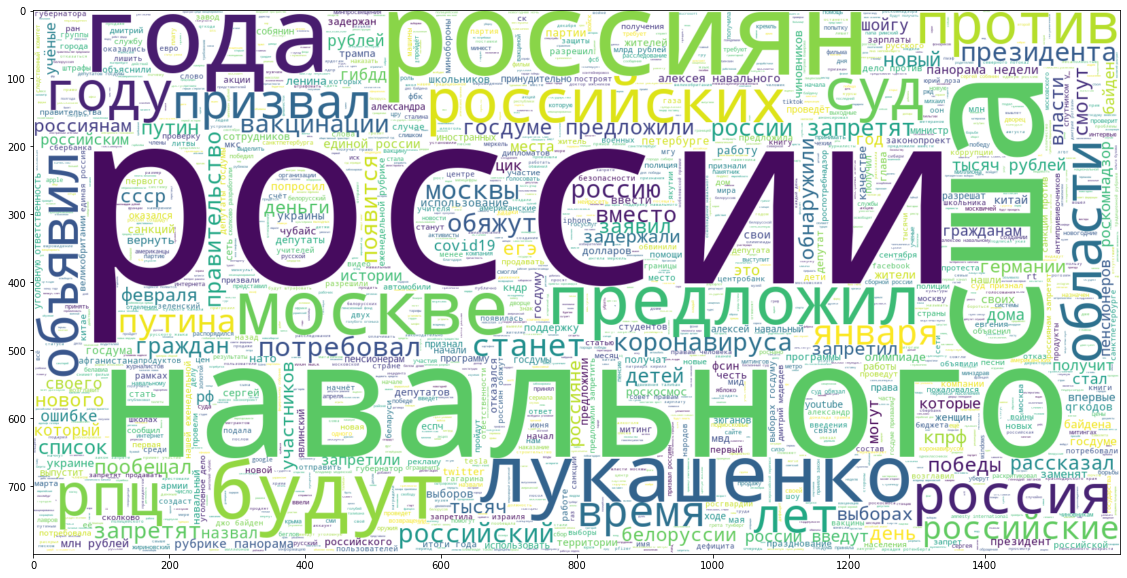

In [13]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(max_words=2000, width=1600, height=800, background_color="white").generate(
    " ".join(data[data["is_fake"] == 1]["title_cleaned"])
)
plt.imshow(word_cloud, interpolation="bilinear");

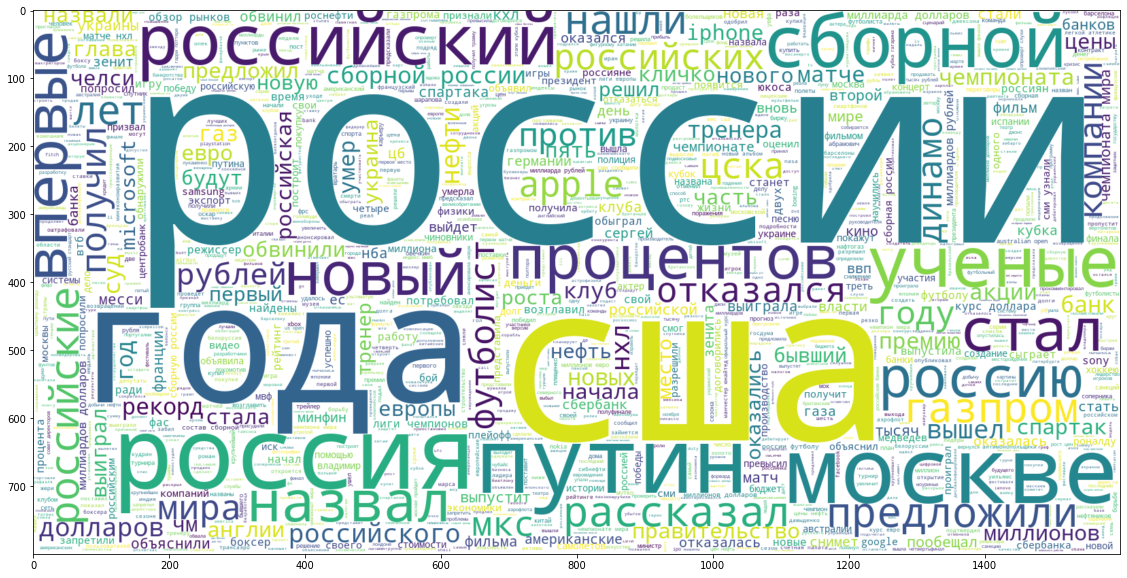

In [14]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(max_words=2000, width=1600, height=800, background_color="white").generate(
    " ".join(data[data["is_fake"] == 0]["title_cleaned"])
)
plt.imshow(word_cloud, interpolation="bilinear");

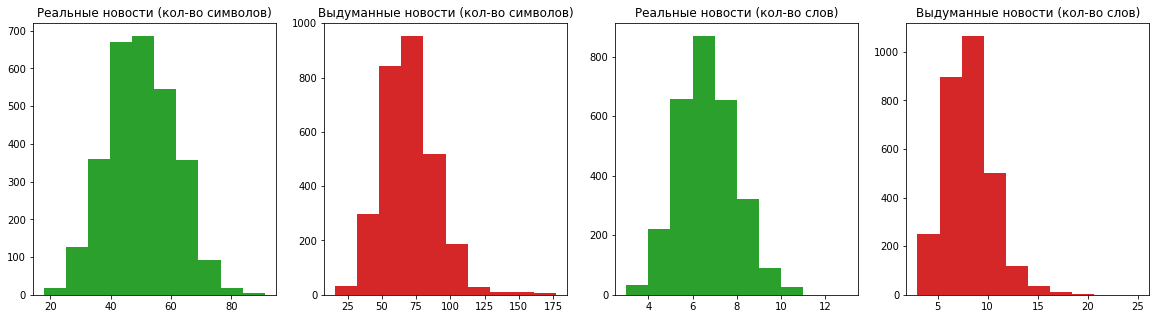

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
text_length = data[data["is_fake"] == 0]["title_cleaned"].str.len()
ax1.hist(text_length, color="tab:green")
ax1.set_title("Реальные новости (кол-во символов)")
text_length = data[data["is_fake"] == 1]["title_cleaned"].str.len()
ax2.hist(text_length, color="tab:red")
ax2.set_title("Выдуманные новости (кол-во символов)")

words_in_title = (
    data[data["is_fake"] == 0]["title_cleaned"].str.split().map(lambda x: len(x))
)
ax3.hist(words_in_title, color="tab:green")
ax3.set_title("Реальные новости (кол-во слов)")
words_in_title = (
    data[data["is_fake"] == 1]["title_cleaned"].str.split().map(lambda x: len(x))
)
ax4.hist(words_in_title, color="tab:red")
ax4.set_title("Выдуманные новости (кол-во слов)");

# Modeling

там по мелочам переименовал переменные и все такое, потому что обычно по таким мелочам как раз и определяют seniority кандидата…

в конце тебе надо расписать прям со ссылками какие есть подходы в fake detection потому что это популярная тема в гугле дофига ссылок. Ты 30 минут потрать, собери и перечисли источники, чтобы показать что ты можешь в ресерч и гугл

я бы еще потратил время на EDA у тебя крутые визуализации, но можно например еще токенизировать и сделать  count токенов в каждой группе, похоже на то, что ты в word cloud сделал. 

Можно еще взять библиотеки для сентимента и посмотрнеть если значимо разный сентимент в каждой группе, если есть, то это будет интересная находка

Еще можно на части речи разложить и там посмотреть есть ли разница по группам, можен например в фейк ньюс чаще используют имена собственные и тд

#### еще было бы круто если бы сделал более generic рещение написал бы функцию-обертку, которая принимает на вход encoder и классификатор и возвращает предсказания.

тогда бы мог взять 2-3 энкодера с skit-learn и все твои модели и пробежаться красивым циклом собрав все предсказания и метрики


In [16]:
# to lower case
data["title_cleaned"] = data["title"].str.lower()
# remove puncluations
data["title_cleaned"] = data["title_cleaned"].apply(
    lambda text: text.translate(str.maketrans("", "", string.punctuation))
)
data["title_cleaned"] = data["title_cleaned"].apply(lambda text: text.replace("«", ""))
data["title_cleaned"] = data["title_cleaned"].str.strip()

In [17]:
data

,title,is_fake,title_cleaned
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,москвичу владимиру клутину пришёл счёт за вмеш...
1,Агент Кокорина назвал езду по встречке житейск...,0,агент кокорина назвал езду по встречке житейск...
2,Госдума рассмотрит возможность введения секрет...,1,госдума рассмотрит возможность введения секрет...
3,ФАС заблокировала поставку скоростных трамваев...,0,фас заблокировала поставку скоростных трамваев...
4,Против Навального завели дело о недоносительст...,1,против навального завели дело о недоносительст...
...,...,...,...
5753,Эдди Чемберс получил сотрясение мозга в бою с ...,0,эдди чемберс получил сотрясение мозга в бою с ...
5754,Правительство застроит Россию нефтепродуктопро...,0,правительство застроит россию нефтепродуктопро...
5755,«Мне стыдно перед дедом»: новый канцлер ФРГ об...,1,мне стыдно перед дедом» новый канцлер фрг обра...
5756,Туркмения в декабре начнет поставки газа в Китай,0,туркмения в декабре начнет поставки газа в китай


In [18]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=118)

## Fasttext

In [19]:
data_train["fasttext_label"] = data_train["is_fake"].apply(
    lambda label: f"__label__{label}"
)
data_train[["title_cleaned", "fasttext_label"]].to_csv(
    "fasttext_corpus.txt",
    sep=" ",
    index=False,
    header=None,
)

In [20]:
model = fasttext.train_supervised(
    "fasttext_corpus.txt",
    dim=200,
    wordNgrams=1,
    ws=1,
    minn=1,
    maxn=200,
    epoch=25,
    thread=psutil.cpu_count(),
)

Read 0M words
Number of words:  18575
Number of labels: 2
Progress: 100.0% words/sec/thread:   27661 lr:  0.000000 avg.loss:  0.515480 ETA:   0h 0m 0s


In [21]:
model.predict("Навальный")[0][0]

'__label__1'

In [22]:
data_test["ft_prediction"] = data_test["title_cleaned"].apply(
    lambda title: int(model.predict(title)[0][0].replace("__label__", ""))
)

In [23]:
data_test.head()

,title,is_fake,title_cleaned,ft_prediction
1478,Siemens порвет с российскими компаниями из-за ...,0,siemens порвет с российскими компаниями изза п...,1
4178,Квят раскритиковал поведение чемпиона «Формулы...,0,квят раскритиковал поведение чемпиона формулы1...,1
3759,"В Белоруссии ликвидируют СМИ, недостаточно осв...",1,в белоруссии ликвидируют сми недостаточно осве...,1
2729,"Комплексы «Бук», развернутые под Минском, возв...",1,комплексы бук» развернутые под минском возвращ...,1
2812,Нидерланды закупят сушёный конский навоз для о...,1,нидерланды закупят сушёный конский навоз для о...,1


In [24]:
print(classification_report(data_test["is_fake"], data_test["ft_prediction"]))

              precision    recall  f1-score   support

           0       0.93      0.08      0.14       543
           1       0.55      1.00      0.71       609

    accuracy                           0.56      1152
   macro avg       0.74      0.54      0.42      1152
weighted avg       0.73      0.56      0.44      1152



In [25]:
results = {}
results["fasttext"] = classification_report(
    data_test["is_fake"], data_test["ft_prediction"], output_dict=True
)

## TF-IDf

In [26]:
from sklearn.model_selection import train_test_split

texts_train = data_train["title_cleaned"].values.tolist()
texts_test = data_test["title_cleaned"].values.tolist()
y_train = data_train["is_fake"].values.tolist()
y_test = data_test["is_fake"].values.tolist()

In [27]:
import itertools

from sklearn import metrics
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfVectorizer,
)
from sklearn.linear_model import (
    LogisticRegression,
    PassiveAggressiveClassifier,
    SGDClassifier,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

In [28]:
count_vect = CountVectorizer()
tfidf = TfidfVectorizer()

count_train = count_vect.fit_transform(texts_train)
count_test = count_vect.transform(texts_test)

tfidf_train = tfidf.fit_transform(texts_train)
tfidf_test = tfidf.transform(texts_test)



In [29]:
count_train.shape, count_test.shape, tfidf_train.shape, tfidf_test.shape

((4606, 16137), (1152, 16137), (4606, 16137), (1152, 16137))

In [30]:
mn_count_clf = MultinomialNB(alpha=0.1)

In [31]:
mn_count_clf.fit(count_train, y_train)
pred = mn_count_clf.predict(count_test)
score = metrics.f1_score(y_test, pred)
results["MultinomialNBCountVectorizer"] = classification_report(
    y_test, pred, output_dict=True
)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       543
           1       0.84      0.86      0.85       609

    accuracy                           0.84      1152
   macro avg       0.84      0.84      0.84      1152
weighted avg       0.84      0.84      0.84      1152



In [32]:
mn_tfidf_clf = MultinomialNB(alpha=0.1)

In [33]:
mn_tfidf_clf.fit(tfidf_train, y_train)
pred = mn_tfidf_clf.predict(tfidf_test)
results["MultinomialNBTfIdfVectorizer"] = classification_report(
    y_test, pred, output_dict=True
)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       543
           1       0.83      0.86      0.84       609

    accuracy                           0.83      1152
   macro avg       0.83      0.83      0.83      1152
weighted avg       0.83      0.83      0.83      1152



In [34]:
pa_tfidf_clf = PassiveAggressiveClassifier(n_iter_no_change=50)

In [35]:
pa_tfidf_clf.fit(tfidf_train, y_train)
pred = pa_tfidf_clf.predict(tfidf_test)
results["PassiveAggressiveClassifierTfIdfVectorizer"] = classification_report(
    y_test, pred, output_dict=True
)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       543
           1       0.84      0.85      0.85       609

    accuracy                           0.84      1152
   macro avg       0.84      0.84      0.84      1152
weighted avg       0.84      0.84      0.84      1152



In [36]:
svc_tfidf_clf = LinearSVC()

In [37]:
svc_tfidf_clf.fit(tfidf_train, y_train)
pred = svc_tfidf_clf.predict(tfidf_test)
results["SVCTfIdfVectorizer"] = classification_report(y_test, pred, output_dict=True)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       543
           1       0.84      0.85      0.85       609

    accuracy                           0.84      1152
   macro avg       0.84      0.84      0.84      1152
weighted avg       0.84      0.84      0.84      1152



In [38]:
sgd_tfidf_clf = SGDClassifier()

In [39]:
sgd_tfidf_clf.fit(tfidf_train, y_train)
pred = sgd_tfidf_clf.predict(tfidf_test)
results["SGDTfIdfVectorizer"] = classification_report(y_test, pred, output_dict=True)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       543
           1       0.85      0.85      0.85       609

    accuracy                           0.84      1152
   macro avg       0.84      0.84      0.84      1152
weighted avg       0.84      0.84      0.84      1152



In [40]:
lr_tfidf_clf = LogisticRegression(C=12.0)

In [41]:
lr_tfidf_clf.fit(tfidf_train, y_train)
pred = lr_tfidf_clf.predict(tfidf_test)
results["LogisticRegressionTfIdfVectorizer"] = classification_report(
    y_test, pred, output_dict=True
)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       543
           1       0.84      0.85      0.85       609

    accuracy                           0.84      1152
   macro avg       0.84      0.84      0.84      1152
weighted avg       0.84      0.84      0.84      1152



In [42]:
lr_count_clf = LogisticRegression(C=12.0)

In [43]:
lr_count_clf = lr_count_clf.fit(count_train, y_train)
pred = lr_count_clf.predict(count_test)
results["LogisticRegressionCountVectorizer"] = classification_report(
    y_test, pred, output_dict=True
)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       543
           1       0.89      0.77      0.82       609

    accuracy                           0.83      1152
   macro avg       0.83      0.83      0.83      1152
weighted avg       0.83      0.83      0.83      1152



## ROC-curve

<Figure size 432x288 with 0 Axes>

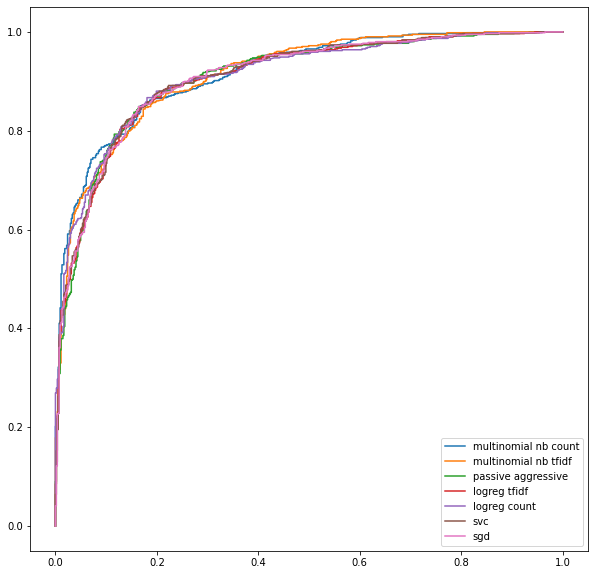

In [44]:
plt.figure(0).clf()
plt.figure(figsize=(10, 10))

for model, name in [
    (mn_count_clf, "multinomial nb count"),
    (mn_tfidf_clf, "multinomial nb tfidf"),
    (pa_tfidf_clf, "passive aggressive"),
    (lr_tfidf_clf, "logreg tfidf"),
    (lr_count_clf, "logreg count"),
    (svc_tfidf_clf, "svc"),
    (sgd_tfidf_clf, "sgd"),
]:
    if "count" in name:
        pred = model.predict_proba(count_test)[:, 1]
    elif "multinomial" in name:
        pred = model.predict_proba(tfidf_test)[:, 1]
    else:
        pred = model.decision_function(tfidf_test)
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred, pos_label=1)
    plt.plot(fpr, tpr, label="{}".format(name))

plt.legend(loc=0);

### Combined report

In [45]:
# NOTE: make some better visualizations : ) 

In [46]:
f1_scores_by_model_class_1 = [(results[model]["1"]["f1-score"], model) for model in results]

In [47]:
pd.DataFrame(f1_scores_by_model_class_1)

,0,1
0,0.706294,fasttext
1,0.849515,MultinomialNBCountVectorizer
2,0.843296,MultinomialNBTfIdfVectorizer
3,0.847596,PassiveAggressiveClassifierTfIdfVectorizer
4,0.848039,SVCTfIdfVectorizer
5,0.849427,SGDTfIdfVectorizer
6,0.848039,LogisticRegressionTfIdfVectorizer
7,0.824253,LogisticRegressionCountVectorizer


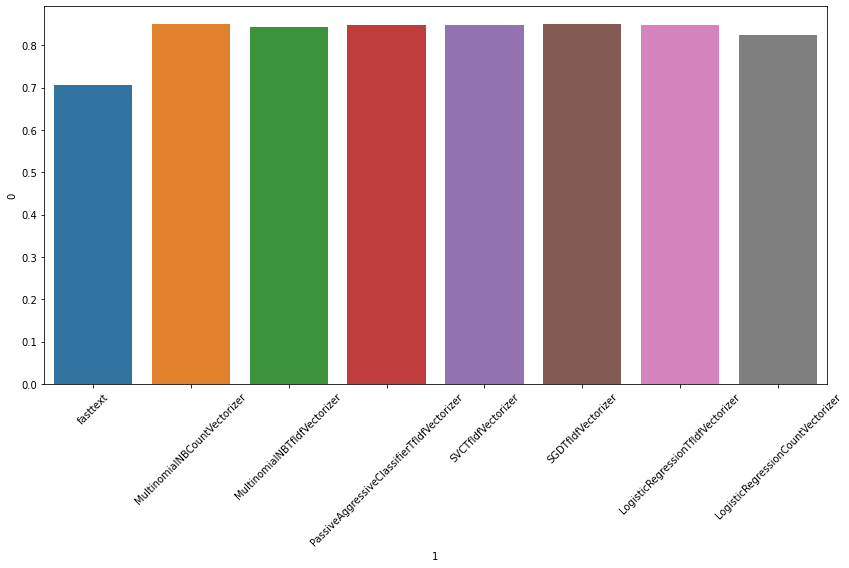

In [48]:
plt.figure(figsize=(12, 8))
sns.barplot(data=pd.DataFrame(f1_scores_by_model_class_1), x=1, y=0)
plt.xticks(rotation=45)
plt.tight_layout()

### Let's try Universal Sentence Encoder

In [49]:
import tensorflow_hub as hub
import tensorflow_text

2022-04-07 17:09:07.890317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-07 17:09:07.890342: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [50]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")

2022-04-07 17:09:09.735234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 17:09:09.735398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-07 17:09:09.735453: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-07 17:09:09.735497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-07 17:09:09.735541: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [51]:
data_matrix = embed(data.title.tolist())

2022-04-07 17:09:12.549256: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 588272640 exceeds 10% of free system memory.
2022-04-07 17:09:13.250345: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 588272640 exceeds 10% of free system memory.
2022-04-07 17:09:13.625670: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 588272640 exceeds 10% of free system memory.
2022-04-07 17:09:13.723175: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 588272640 exceeds 10% of free system memory.
2022-04-07 17:09:13.822044: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 588272640 exceeds 10% of free system memory.


In [52]:
train_data = data.loc[0:int(len(data)*0.8)]
test_data = data.loc[int(len(data)*0.8):len(data)]

In [53]:
from sklearn.decomposition import PCA

In [54]:
pca = PCA(n_components=3)
pca_data = pca.fit()
pca_train = pca.transform()

In [59]:
pca_3_data = pd.DataFrame({'First Component':pca_train[:,0],'Second Component':pca_train[:,1],'Third Component':pca_train[:,2],'Target': train_data.is_fake})

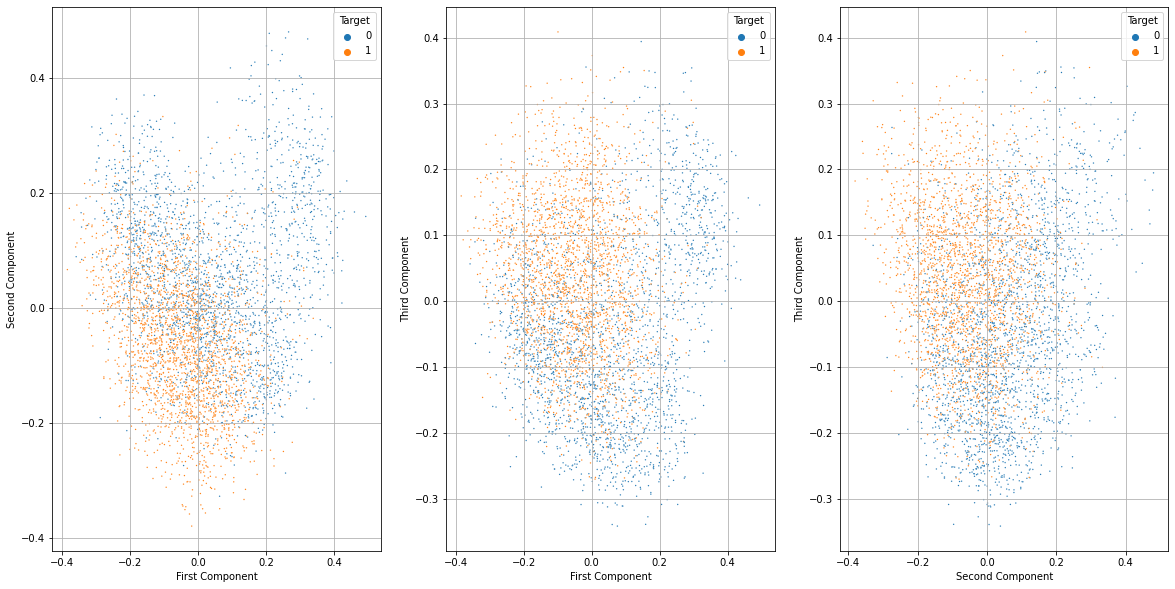

In [60]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
sns.scatterplot(x='First Component', y = 'Second Component',hue='Target',data=pca_3_data,s=2)
plt.grid(True)
plt.subplot(1,3,2)
sns.scatterplot(x='First Component', y = 'Third Component',hue='Target',data=pca_3_data,s=2)
plt.grid(True)
plt.subplot(1,3,3)
sns.scatterplot(x='Second Component', y = 'Third Component',hue='Target',data=pca_3_data,s=2)
plt.grid(True)